In [2]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import nltk
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

data = pd.read_csv("/content/Sentiment_Scores.csv")

print(data[data.Rating == 0].count()/len(data))
print(data[data.Rating == 1].count()/len(data))
print(data[data.Rating == 2].count()/len(data))
print(data[data.Rating == 3].count()/len(data))



Text      0.17931
Rating    0.17931
dtype: float64
Text      0.310345
Rating    0.310345
dtype: float64
Text      0.324138
Rating    0.324138
dtype: float64
Text      0.186207
Rating    0.186207
dtype: float64


In [3]:
# Convert to characters (numbers)
# Output is a list of lists of embeddings
def character_encode(allData):

    voc2ind = {}
    output = []
    maxKey = 0
    for data in allData:
      # Remove multiple whitespaces
      data = ' '.join(data.split())
     
      newData = np.zeros(len(data), dtype = int);
      idx = 0
      # print(len(data))

      # Compute voc2ind and transform the data into an integer representation of the tokens.
      for char in data:
        if char not in voc2ind:
          voc2ind[char] = maxKey
          maxKey += 1  
        newData[idx] = voc2ind[char]
        idx += 1

      output.append(newData)

    ind2voc = {val: key for key, val in voc2ind.items()}
    # print(len(ind2voc))
    return output, ind2voc, voc2ind
output, ind2voc, voc2ind = character_encode(data.Text.to_list())

In [4]:
# Run this for standard padding data in our vector
pad_value = -1;
max_seq_len = max([len(seq) for seq in output])
padded_seqs = np.full((len(output), max_seq_len, 1), fill_value = pad_value)
for s, x in enumerate(output):
  seq_len = x.shape[0]
  padded_seqs[s, 0:seq_len, :] = np.expand_dims(x, axis=1)


In [ ]:
# If we want to pad to a specific sequence length
pad_value = -1
from keras.preprocessing.sequence import pad_sequences
max_seq_len = 1000
padded_seqs = pad_sequences(output, value = pad_value, maxlen = max_seq_len)

In [ ]:
# Run this if we want to increase our data by sampling more (subsampling)
import random

def subsample(x, y, length, n):
  newx = []
  newy = []

  for _ in range(n):
    for curX in x:
      maxVal = curX.shape[0] - length
      start = random.randint(0, maxVal)
      newx.append(curX[start:start+length])
    for curY in y:
      newy.append(curY)

  return np.array(newx), np.array(newy)

maxlen = 100
samps = 10
newx, newy = subsample(output, data.Rating.to_list(), maxlen, samps)
len(newy)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(newx, newy, shuffle = True, train_size = 0.8)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = to_categorical(np.array(y_train))
y_test = to_categorical(np.array(y_test))


In [5]:
import math
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Masking
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.utils import to_categorical

In [6]:
# Partition our data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_seqs, data.Rating.to_list(), shuffle = True)

X_train = np.array(X_train)
X_test = np.array(X_test)

# Uncomment this and comment the other y_train y_test out if we want to:
# Convert our ys to be binary: 0 is negative, 1 is positive
# y_train = to_categorical(np.where(np.array(y_train) > 1.1, 0, 1))
# y_test = to_categorical(np.where(np.array(y_test) > 1.1, 0, 1))

y_train = to_categorical(np.array(y_train))
y_test = to_categorical(np.array(y_test))

In [ ]:
# Experiments to train mdoel and get accuarcy
# Repeat with batch size and learning rate
trials = 3
nodes = [10, 25, 50, 100, 200]
epochs = [3, 5, 10, 20]
bs = [8, 16, 32]

resultsMean = []
resultsStd = []

for n in nodes:
  print("NODE")
  print(n)
  curResultMean = []
  curResultStd = []
  for e in epochs:
    curDataAll = []
    for t in range(trials):
      model = Sequential()
      model.add(Masking(mask_value=pad_value, input_shape=(max_seq_len, 1)))
      model.add(LSTM(n,return_sequences=True))
      model.add(LSTM(n))
      # model.add(Dropout(0.1))
      model.add(Dense(4, activation='softmax'))

      opt = Adam(learning_rate=0.01)
      model.compile(loss="categorical_crossentropy", optimizer=opt,  metrics=['accuracy'])
      print(model.summary())
      history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=e, verbose=1, batch_size=16)
      curDataAll.append(model.evaluate(X_test, y_test)[1])

    curResultMean.append(np.mean(curDataAll))
    curResultStd.append(np.std(curDataAll))
  resultsMean.append(curResultMean)
  resultsStd.append(curResultStd)

NODE
10
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_45 (Masking)         (None, 11344, 1)          0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 11344, 10)         480       
_________________________________________________________________
lstm_46 (LSTM)               (None, 10)                840       
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 44        
Total params: 1,364
Trainable params: 1,364
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
7/7 [==============================] - 11s 769ms/step - loss: 1.4312 - accuracy: 0.2901 - val_loss: 1.3675 - val_accuracy: 0.2973
Epoch 2/3
7/7 [==============================] - 3s 376ms/step - loss: 1.3598 - accuracy: 0.3490

KeyboardInterrupt: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

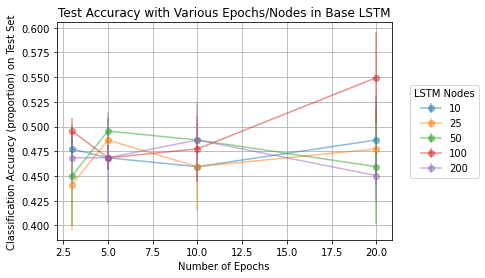

In [21]:
# plot above
import matplotlib.pyplot as plt

for i in range(len(resultsMean)):
  plt.errorbar(epochs, resultsMean[i], resultsStd[i], marker = 'o', alpha = 0.5)
plt.grid()
plt.title("Test Accuracy with Various Epochs/Nodes in Base LSTM")
plt.ylabel("Classification Accuracy (proportion) on Test Set")
plt.xlabel("Number of Epochs")
lgd = plt.legend(nodes, title="LSTM Nodes", bbox_to_anchor=(1.04,0.5), loc="center left")
from google.colab import files
plt.savefig("binary.png",bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 1000)
files.download("binary.png")


In [20]:
# Train just one model
model = Sequential()
model.add(Masking(mask_value=pad_value, input_shape=(max_seq_len, 1)))
model.add(Bidirectional(LSTM(25)))
model.add(Dense(4, activation='softmax'))

opt = Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt,  metrics=['accuracy'])
# print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1, batch_size=16)
i+=1
acc = model.evaluate(X_test, y_test)[1]

0
Epoch 1/20
7/7 [==============================] - 11s 757ms/step - loss: 1.5519 - accuracy: 0.1981 - val_loss: 1.4093 - val_accuracy: 0.2973
Epoch 2/20
7/7 [==============================] - 3s 387ms/step - loss: 1.3871 - accuracy: 0.3280 - val_loss: 1.3779 - val_accuracy: 0.2703
Epoch 3/20
7/7 [==============================] - 3s 380ms/step - loss: 1.3318 - accuracy: 0.3373 - val_loss: 1.3541 - val_accuracy: 0.4054
Epoch 4/20
7/7 [==============================] - 3s 374ms/step - loss: 1.3212 - accuracy: 0.3683 - val_loss: 1.3670 - val_accuracy: 0.2973
Epoch 5/20
7/7 [==============================] - 3s 378ms/step - loss: 1.2949 - accuracy: 0.3758 - val_loss: 1.3772 - val_accuracy: 0.3243
Epoch 6/20
7/7 [==============================] - 3s 447ms/step - loss: 1.3104 - accuracy: 0.3555 - val_loss: 1.3741 - val_accuracy: 0.3514
Epoch 7/20
7/7 [==============================] - 3s 405ms/step - loss: 1.2939 - accuracy: 0.4107 - val_loss: 1.3977 - val_accuracy: 0.2703
Epoch 8/20
7/7 [=

In [21]:
print(X_test.shape)
model.predict(X_test[0:2])
#t = model.evaluate(X_test, y_test)[1]
#t
# history.history["accuracy"][-1]

(37, 11344, 1)


array([[0.16884552, 0.31558228, 0.47503775, 0.04053449],
       [0.17802121, 0.24426134, 0.30018187, 0.2775356 ]], dtype=float32)

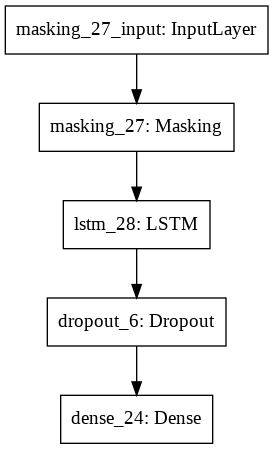

In [ ]:
# plot our model
from keras.utils import plot_model
plot_model(model)

In [50]:
# Run this to predict sentiment from phrases
def predict_sentiment(phrases):
  output, ind2voc, voc2ind = character_encode(phrases)

  padded_seqs = np.full((len(output), max_seq_len, 1), fill_value = pad_value)
  for s, x in enumerate(output):
    seq_len = x.shape[0]
    padded_seqs[s, 0:seq_len, :] = np.expand_dims(x, axis=1)
  prediction = model.predict(padded_seqs)
  curClass = np.argmax(prediction, axis = 1)
  for c in curClass:
    if c == 0:
      print("Extremely unhappy/discontent")
    elif c==1:
      print("Somewhat unhappy/discontent")
    elif c==2:
      print("Somewhat happy/content")
    elif c==3:
      print("Extremely happy/content")

In [136]:
# Enter phrases as strings in a list and run this cell
phrases = [""]
predict_sentiment(phrases)

Somewhat unhappy/discontent


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

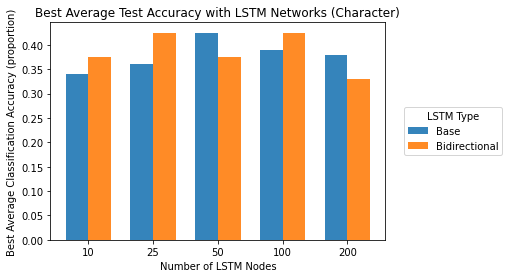

In [36]:
import matplotlib.pyplot as plt
import numpy as np

xChar = [10, 25, 50, 100, 200]
baseChar = [0.34, 0.36, 0.425, 0.39, 0.38]
biChar = [0.375, 0.425, 0.375, 0.425, 0.33]
bar_width = 0.35
fig, ax = plt.subplots()
ax.bar(np.arange(len(xChar)), baseChar, bar_width, alpha = 0.9)
ax.bar(np.arange(len(xChar))+bar_width, biChar, bar_width, alpha = 0.9)
plt.title("Best Average Test Accuracy with LSTM Networks (Character)")
plt.ylabel("Best Average Classification Accuracy (proportion)")
plt.xlabel("Number of LSTM Nodes")
ax.set_xticks(np.arange(len(xChar))+ bar_width / 2)
ax.set_xticklabels(xChar)
lgd = plt.legend(["Base", "Bidirectional"], title="LSTM Type", bbox_to_anchor=(1.04,0.5), loc="center left")


# from google.colab import files
# filename = "best_char.png"
# plt.savefig(filename,bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 1000)
# files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

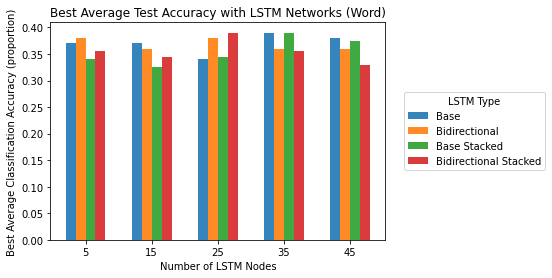

In [46]:
import matplotlib.pyplot as plt
import numpy as np

xWord = [5, 15, 25, 35, 45]
baseWord = [0.37,0.37,0.34,0.39,0.38]
biWord = [0.38,0.36,0.38,0.36,0.36]
baseWordStacked = [0.34,0.325,0.345,0.39,0.375]
biWordStacked = [0.355,0.345,0.39,0.355,0.33]
bar_width = 0.15
fig, ax = plt.subplots()
ax.bar(np.arange(len(xWord))-2*bar_width, baseWord, bar_width, alpha = 0.9)
ax.bar(np.arange(len(xWord))-bar_width, biWord, bar_width, alpha = 0.9)
ax.bar(np.arange(len(xWord)), baseWordStacked, bar_width, alpha = 0.9)
ax.bar(np.arange(len(xWord))+bar_width, biWordStacked, bar_width, alpha = 0.9)

plt.title("Best Average Test Accuracy with LSTM Networks (Word)")
plt.ylabel("Best Average Classification Accuracy (proportion)")
plt.xlabel("Number of LSTM Nodes")
ax.set_xticks(np.arange(len(xWord))-bar_width/2)
ax.set_xticklabels(xWord)
lgd = plt.legend(["Base", "Bidirectional","Base Stacked", "Bidirectional Stacked"], title="LSTM Type", bbox_to_anchor=(1.04,0.5), loc="center left")


from google.colab import files
filename = "best_Word.png"
plt.savefig(filename,bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 1000)
files.download(filename)